# Solving the wave equation fro c = 4
# using sinusoidal basis  


In [29]:
import deepxde as dde
import matplotlib.pyplot as plt
from deepxde.backend import torch 
import numpy as np 

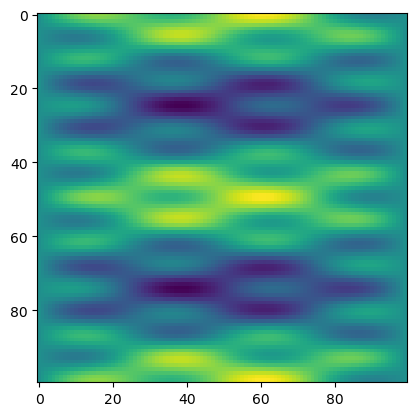

In [30]:
def pde(x,y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_tt = dde.grad.hessian(y, x, i=1, j=1)

    res = dy_tt - 16*dy_xx
    return res 

def func(x):
    return np.sin(np.pi*x[:,0:1])*np.cos(4*np.pi*x[:,1:2]) + 0.5*np.sin(4*np.pi*x[:,0:1])*np.cos(16*np.pi*x[:,1:2])

def func_plot(x,t):
    return np.sin(np.pi*x)*np.cos(4*np.pi*t) + 0.5*np.sin(4*np.pi*x)*np.cos(16*np.pi*t)
x = np.linspace(0,1,100)
t = np.linspace(0,1,100)
X,T = np.meshgrid(x,t)

plt.imshow(func_plot(X,T))



In [31]:

geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic_1 = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
# do not use dde.NeumannBC here, since `normal_derivative` does not work with temporal coordinate.
ic_2 = dde.icbc.OperatorBC(
    geomtime,
    lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=1),
    lambda x, _: dde.utils.isclose(x[1], 0),
)

In [32]:
def output_transform(x,y):
    X = x[:,0:1]
    T = x[:,1:2]
    res = 0.0
    for n in range(1,5):
        res = res + y[:,n-1:n]*torch.cos(n*np.pi*4*T)*torch.sin(n*np.pi*X)
    return res





In [33]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic_1, ic_2],
    num_domain=10000,
    num_boundary=360,
    num_initial=360,
    solution=func,
    num_test=10000,
)

layer_size = [2] + [100] * 6 + [4]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(
    layer_size, activation, initializer
)
net.apply_feature_transform(lambda x: (x - 0.5) * 2 * np.sqrt(3))
net.apply_output_transform(output_transform)

In [34]:
layer_size_1 = [2] + [100] * 6 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net1 = dde.nn.FNN(
    layer_size_1, activation, initializer
)
net1.apply_feature_transform(lambda x: (x - 0.5) * 2 * np.sqrt(3))
#net.apply_output_transform(output_transform)

In [35]:
model = dde.Model(data, net)

model.compile(
    "adam",
    lr=0.001,
    metrics=["l2 relative error"],
    
)


model1 = dde.Model(data, net1)

model1.compile(
    "adam",
    lr=0.001,
    metrics=["l2 relative error"],
    
)

Compiling model...
'compile' took 0.000339 s

Compiling model...
'compile' took 0.000464 s



In [36]:

losshistory, train_state = model.train(
    iterations=5000, display_every=1000
)



losshistory1, train_state1 = model1.train(
    iterations=5000, display_every=1000
)

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [2.40e+04, 1.74e-14, 7.68e-01, 9.09e-02]    [2.32e+04, 1.74e-14, 7.68e-01, 9.09e-02]    [1.06e+00]    
1000      [6.53e-02, 1.32e-17, 2.77e-03, 1.49e-04]    [5.44e-02, 1.32e-17, 2.77e-03, 1.49e-04]    [6.66e-02]    
2000      [2.02e-02, 7.76e-21, 1.44e-06, 6.65e-05]    [1.68e-02, 7.76e-21, 1.44e-06, 6.65e-05]    [1.61e-03]    
3000      [1.01e-02, 1.61e-21, 1.17e-07, 2.69e-05]    [8.62e-03, 1.61e-21, 1.17e-07, 2.69e-05]    [4.99e-04]    
4000      [4.91e-03, 5.82e-22, 3.37e-08, 8.71e-06]    [4.15e-03, 5.82e-22, 3.37e-08, 8.71e-06]    [2.61e-04]    
5000      [1.62e-02, 1.04e-20, 1.21e-06, 8.74e-06]    [1.44e-02, 1.04e-20, 1.21e-06, 8.74e-06]    [1.45e-03]    

Best model at step 4000:
  train loss: 4.91e-03
  test loss: 4.16e-03
  test metric: [2.61e-04]

'train' took 242.485979 s

Training model...

Step      Train loss                          

Saving loss history to /home/vemuri/Desktop/BasisPINNs/loss.dat ...
Saving training data to /home/vemuri/Desktop/BasisPINNs/train.dat ...
Saving test data to /home/vemuri/Desktop/BasisPINNs/test.dat ...


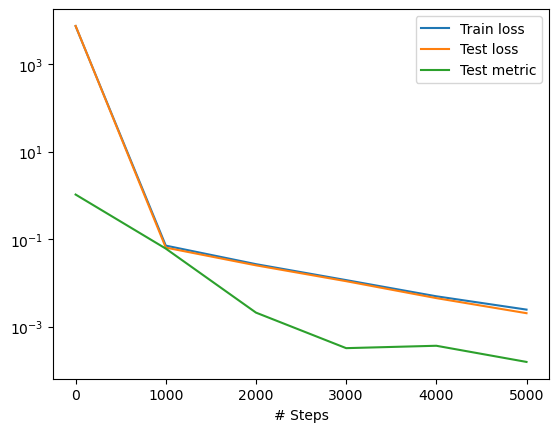

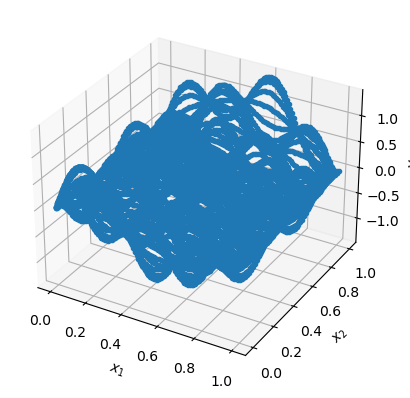

In [24]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


Saving loss history to /home/vemuri/Desktop/BasisPINNs/loss.dat ...
Saving training data to /home/vemuri/Desktop/BasisPINNs/train.dat ...
Saving test data to /home/vemuri/Desktop/BasisPINNs/test.dat ...


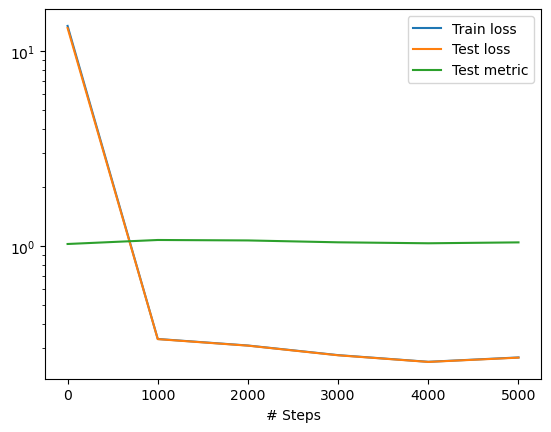

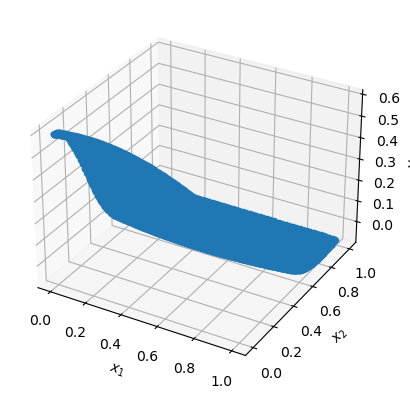

In [37]:
dde.saveplot(losshistory1, train_state1, issave=True, isplot=True)

In [38]:
x_test= []
for i in x:
    for j in t:
        x_test.append([i,j])

In [39]:
u_preds = model.predict(x_test)
u_preds_1= model1.predict(x_test)
u_true = func(np.array(x_test))

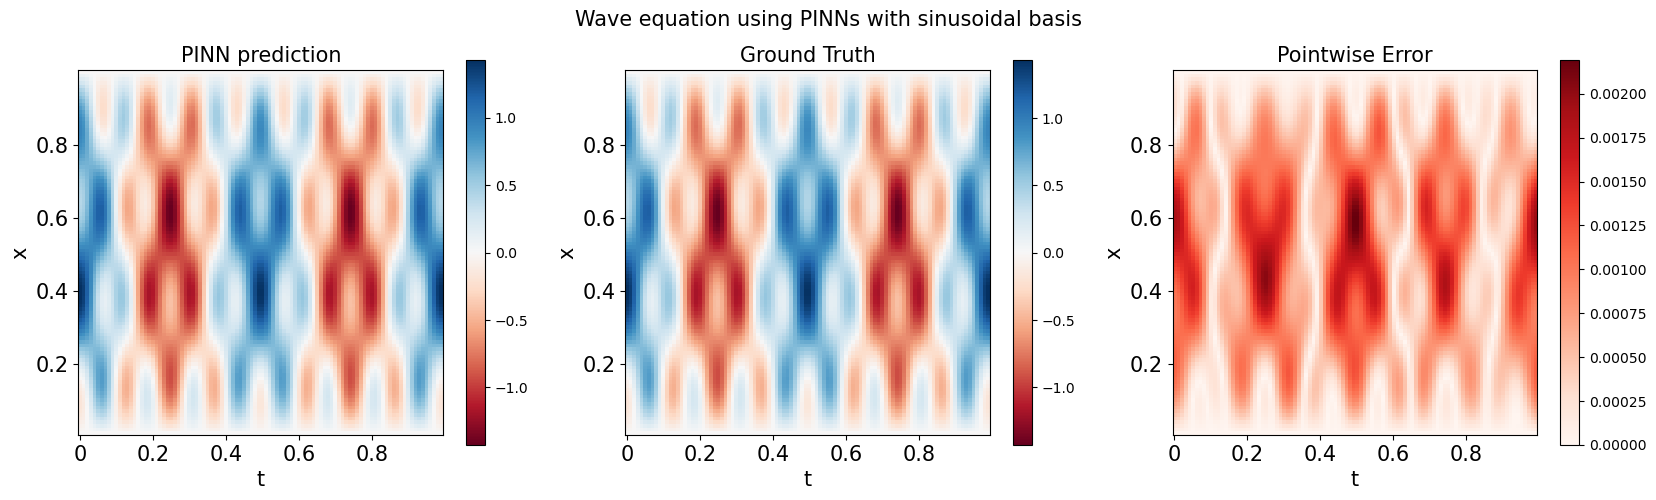

In [40]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
im1 = ax[0].imshow(u_preds.reshape((100,100)),cmap="RdBu")
fig.colorbar(im1)
im2 = ax[1].imshow(u_true.reshape((100,100)),cmap="RdBu")
fig.colorbar(im2)
xticks= [0,20,40,60,80]
xlabels = [0,0.2,0.4,0.6,0.8]
yticks =[80,60,40,20]
ylabels=[0.2,0.4,0.6,0.8]
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xlabels)
ax[0].set_yticks(yticks)
ax[0].set_yticklabels(ylabels)
im3= ax[2].imshow(np.abs(u_true-u_preds).reshape((100,100)),cmap="Reds")
fig.colorbar(im3)
ax[0].set_title("PINN prediction",fontsize=15)
ax[0].set_xlabel("t",fontsize=15)
ax[0].set_ylabel("x",fontsize=15)

ax[1].set_title("Ground Truth",fontsize=15)
ax[1].set_xlabel("t",fontsize=15)
ax[1].set_ylabel("x",fontsize=15)
ax[2].set_title("Pointwise Error",fontsize=15)
ax[2].set_xlabel("t",fontsize=15)
ax[2].set_ylabel("x",fontsize=15)
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xlabels)
ax[1].set_yticks(yticks)
ax[1].set_yticklabels(ylabels)

ax[2].set_xticks(xticks)
ax[2].set_xticklabels(xlabels)
ax[2].set_yticks(yticks)
ax[2].set_yticklabels(ylabels)
ax[0].xaxis.set_tick_params(labelsize=15)
ax[0].yaxis.set_tick_params(labelsize=15)
ax[1].xaxis.set_tick_params(labelsize=15)
ax[1].yaxis.set_tick_params(labelsize=15)
ax[2].xaxis.set_tick_params(labelsize=15)
ax[2].yaxis.set_tick_params(labelsize=15)
fig.suptitle("Wave equation using PINNs with sinusoidal basis",fontsize=15)
fig.savefig("wave_5basis.pdf",dpi=500)

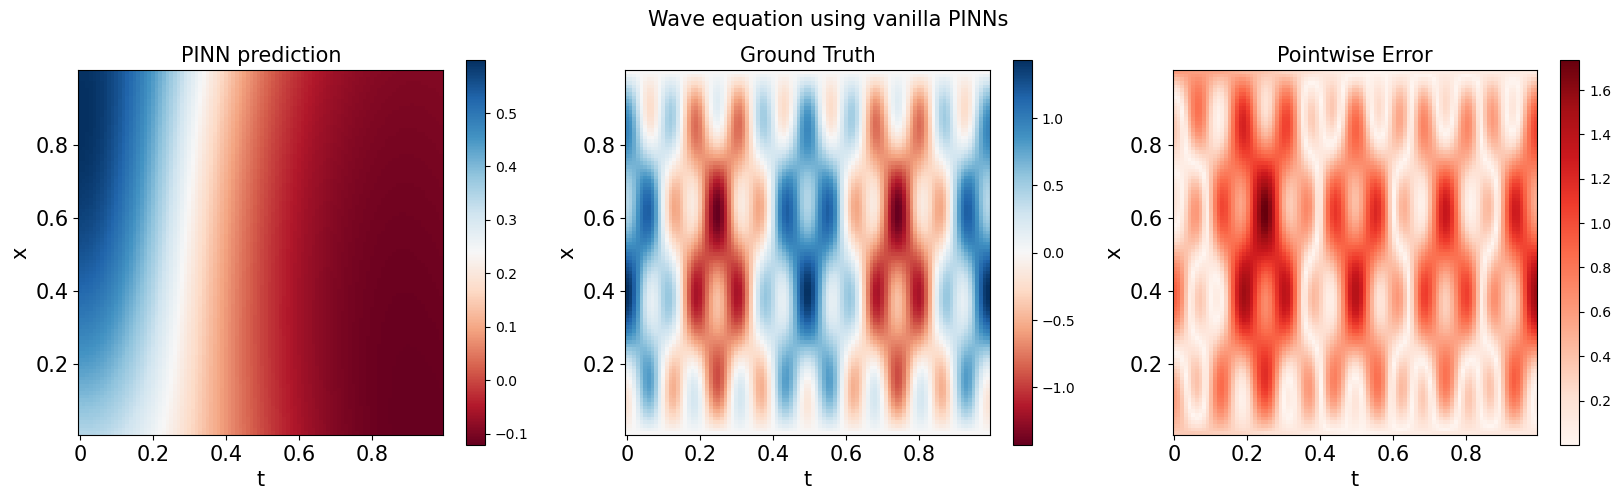

In [41]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
im1 = ax[0].imshow(u_preds_1.reshape((100,100)),cmap="RdBu")
fig.colorbar(im1)
im2 = ax[1].imshow(u_true.reshape((100,100)),cmap="RdBu")
fig.colorbar(im2)
xticks= [0,20,40,60,80]
xlabels = [0,0.2,0.4,0.6,0.8]
yticks =[80,60,40,20]
ylabels=[0.2,0.4,0.6,0.8]
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xlabels)
ax[0].set_yticks(yticks)
ax[0].set_yticklabels(ylabels)
im3= ax[2].imshow(np.abs(u_true-u_preds_1).reshape((100,100)),cmap="Reds")
fig.colorbar(im3)
ax[0].set_title("PINN prediction",fontsize=15)
ax[0].set_xlabel("t",fontsize=15)
ax[0].set_ylabel("x",fontsize=15)

ax[1].set_title("Ground Truth",fontsize=15)
ax[1].set_xlabel("t",fontsize=15)
ax[1].set_ylabel("x",fontsize=15)
ax[2].set_title("Pointwise Error",fontsize=15)
ax[2].set_xlabel("t",fontsize=15)
ax[2].set_ylabel("x",fontsize=15)
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xlabels)
ax[1].set_yticks(yticks)
ax[1].set_yticklabels(ylabels)

ax[2].set_xticks(xticks)
ax[2].set_xticklabels(xlabels)
ax[2].set_yticks(yticks)
ax[2].set_yticklabels(ylabels)
ax[0].xaxis.set_tick_params(labelsize=15)
ax[0].yaxis.set_tick_params(labelsize=15)
ax[1].xaxis.set_tick_params(labelsize=15)
ax[1].yaxis.set_tick_params(labelsize=15)
ax[2].xaxis.set_tick_params(labelsize=15)
ax[2].yaxis.set_tick_params(labelsize=15)
fig.suptitle("Wave equation using vanilla PINNs",fontsize=15)
fig.savefig("wave_vanilla.pdf",dpi=500)

In [32]:
print((u_true-u_preds).reshape((100,100)))

[[-0.64335889 -0.64356548 -0.64284348 ...  0.10621931  0.10628265
   0.10626791]
 [-0.54799581 -0.5564008  -0.57833241 ...  0.17048107  0.19322714
   0.20143371]
 [-0.4536248  -0.47009937 -0.51433171 ...  0.23416977  0.27924486
   0.29554464]
 ...
 [-0.38194997 -0.36728043 -0.32534917 ...  0.09924098  0.05672547
   0.04082416]
 [-0.34532607 -0.33833825 -0.31732432 ...  0.10118914  0.07950658
   0.07121412]
 [-0.30767816 -0.30850166 -0.30875915 ...  0.1036396   0.10314256
   0.10258643]]


In [33]:
def plot_function(lx,rx,ly,ry,u_sol,out,method):
    methods=["W1 (uniform)","W2 (max_by_mean)","W3 (std)","W4 (mean+std)","W5 (mean*std)","W6 (kurtosis)"]
    plt.subplot(1,3,1)
    plt.imshow(u_sol, cmap="twilight", origin="lower",vmin=-1.0,vmax=1.0)
    plt.xticks(np.arange(0,101,50),np.linspace(lx,rx,3),fontsize=12)
    plt.yticks(np.arange(0,101,50),np.linspace(ly,ry,3),fontsize=12)
    plt.xlabel(r"$x$",fontsize=15)
    plt.ylabel(r"$y$",fontsize=15)
    plt.title("Ground Truth",fontsize=18)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.subplot(1,3,2)
    plt.imshow(out, cmap="twilight", origin="lower",vmin=-1.0,vmax=1.0)
    plt.xticks(np.arange(0,101,50),np.linspace(lx,rx,3),fontsize=12)
    plt.yticks(np.arange(0,101,50),np.linspace(ly,ry,3),fontsize=12)
    plt.xlabel(r"$x$",fontsize=15)
    plt.ylabel(r"$y$",fontsize=15)
    plt.title("Prediction",fontsize=18)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.subplot(1,3,3)
    plt.imshow(np.abs(out-u_sol)/np.max(np.abs(u_sol)), cmap="nipy_spectral", origin="lower",vmin=0,vmax=0.2)
    plt.xticks(np.arange(0,101,50),np.linspace(lx,rx,3),fontsize=12)
    plt.yticks(np.arange(0,101,50),np.linspace(ly,ry,3),fontsize=12)
    plt.xlabel(r"$x$",fontsize=15)
    plt.ylabel(r"$y$",fontsize=15)
    plt.title("Point-wise Error",fontsize=18)
    plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.gcf().set_size_inches(15,5)
    plt.tight_layout()
    plt.suptitle("Poisson Equation using PINN_{}".format(methods[method]),fontsize=25)
    plt.savefig("PoissonEqn_{}_based".format(methods[method]),dpi=800)
    return None